-------------------------------------------------------------------------------------------------------------------
Implementaion of : "Online Label Recovery for Deep Learning-based communication through Error Correcting codes"

Author : Eric Soubigou

Date : Spring 2019

-------------------------------------------------------------------------------------------------------------------

Description :  Creation of a DFE like with Deep Learning technologies

In [0]:
# Install libraries :
!pip install git+git://github.com/veeresht/CommPy.git@master

  Cloning git://github.com/veeresht/CommPy.git (to revision master) to /tmp/pip-req-build-61ajmzyf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ofsa1ogl/wheels/d1/6a/31/8ddc70e8eb8a1c3ad344032ed43b4ebfccc41007e8850226d0
Successfully built scikit-commpy


In [0]:
## Imports
import time
from __future__ import print_function
import matplotlib.pyplot as plt

# Scipy
import scipy as sp
from scipy import signal
# Numpy
import numpy as np
# Compy
from commpy.filters import *
import commpy as cp

# For DL libraries 
import torch

# Keras
#from keras import backend as K
#from keras.models import Sequential
#from keras.layers.core import Dense, Lambda

In [0]:
### Simulation import
from commpy.channelcoding.convcode import Trellis, conv_encode, viterbi_decode
from commpy.modulation import *


### Simulation initialization

# Channel code parameters + trellis generation
mem_size = np.array([2])
g_matrix = np.array([[0o5, 0o7]])

# Modulation parameters
modulation_order = 2
frame_length = 256

# OFDM parameters
nb_carriers = 64
cp_length = 8
g_i_interval = 0
off_carrier = 0

In [0]:
"""
  Useful functions
"""

""" Return if the number is a power of two. 
"""
def is_power_of_2(num):

	return num != 0 and ((num & (num - 1)) == 0)

def plot_spectrum(signal, time_step):
  # Go in the frequency domain
  spectrum = np.abs(np.fft.fftshift(np.fft.fft(signal)))**2
  f, welch_estimate = sp.signal.welch(signal)
  freq = np.fft.fftshift(np.fft.fftfreq(signal.size, d=time_step))
#   print("Len of freq, spectrum, signal is : ", freq.shape, spectrum.shape, signal.shape)
  #plt.plot(freq, spectrum, 'r')
  plt.plot(f, welch_estimate, 'b')
  plt.yscale('log')
  plt.title('OFDM Spectrogram')
  plt.ylabel('Frequency [Hz]')
  plt.ylabel('Amplitude')
  plt.grid(True)
  plt.show()


In [0]:
"""
  Emitter class
"""

class Emiter:
  """ Class of the emiter.
  
  :cp_len: An integer, length of the cyclic-prefix of the OFDM.
  :nb_carriers: An integer, number of sub_carrier used to transmit data.
  :modulation_order: An integer, the modulation order.
  :nb_off_carriers: An integer, number of off carrier in OFDM scheme
  
  Ex : | CP | CP | OFF | OFF | ON | ON | ... | ON |
  
  """
  def __init__(self, cp_len, nb_carriers, modulation_order, trellis, nb_off_carriers=0):
    self.cp_len = cp_len
    self.nb_carriers = nb_carriers
    self.nb_off_carriers = nb_off_carriers
    # Number of carriers that are used knowing the number of off-carrier
    self.nb_on_carriers = self.nb_carriers - self.nb_off_carriers


    if is_power_of_2(modulation_order):
      self.modulator = cp.modulation.PSKModem(modulation_order)
    else:
      print('Wrong modulation order : modulation order = ', modulation_order)

    # Test if the trellis is well-defined
    if trellis is not None:
      self.enc_trellis = trellis
    else:
      print("trellis is not defined")
      
  def get_trellis(self):
    return self.enc_trellis
      
  """ Modulate and Map the frame. In other words, will perform the Modulation 
  and the Mapping and then perform the OFDM transmormation before sending the 
  data.
  :frame: The frame that has to be modulated.
  """
  def modulate(self, frame):
    # Mapping of the data
    mod_frame = self.modulator.modulate(frame)
#     print("The mapped frame shape is", mod_frame.shape)
    # Test if the division is equal to an integer or not
    if len(mod_frame) % self.nb_on_carriers != 0:
      nb_ofdm_group = (len(mod_frame) // self.nb_on_carriers) + 1
      """ Add padding to the frame in order to get a interger number of PHY 
       frames used.
      """
      padding = np.zeros((self.nb_on_carriers - len(mod_frame) 
                         % self.nb_on_carriers) 
                         * self.modulator.num_bits_symbol,
                         dtype=int)
      
#       print("Add padding of size : ", padding.size,
#             " for a number of PHY frame of ", nb_ofdm_group)
      mod_frame = np.concatenate((mod_frame, self.modulator.modulate(padding)),
                                 axis=0)
    else:
      # No padding to perform
      nb_ofdm_group = len(mod_frame) // self.nb_on_carriers
      
#     print("The number of OFDM PHY frame is : ", nb_ofdm_group)
    # Then shrink the frame to perform the modulation
#     print("The number of on carrier is : ", self.nb_on_carriers)
#       print("Hence the number of symbol will be ", 
#           self.nb_on_carriers*nb_ofdm_group, 
#           " and is actualy ",
#           mod_frame.size)
    
    carriers = np.reshape(mod_frame, (nb_ofdm_group, self.nb_on_carriers))
    #print("The shape of the shrink frame is : ", np.shape(carriers))
    if self.nb_off_carriers > 0:
      # Add the off_carriers
#       print("carriers, off_carriers shape",carriers.shape,
#             np.zeros((nb_ofdm_group, self.nb_off_carriers)).shape)
      carriers = np.concatenate((
          np.zeros((nb_ofdm_group, self.nb_off_carriers)),carriers),
          axis=1)
      
      
    # Then use the matrix to transform them into OFDM symbols
    ofdm_signal = np.zeros(carriers.shape)
    for i in range(nb_ofdm_group):
      ofdm_signal[i,:] = np.fft.ifft(carriers[i,:])
    # Add the cyclic prefix
    #print("ofdm signal cp shape : ", 
    #      np.shape(ofdm_signal[:,self.nb_carriers-self.cp_len:]),
    #      " and for the rest of the signal : ", np.shape(ofdm_signal))
    ofdm_signal_cp = np.concatenate(
        (ofdm_signal[:,self.nb_carriers - self.cp_len:],ofdm_signal),
        axis=1)
    # Return the global frame
    return np.reshape(ofdm_signal_cp, 
                      (nb_ofdm_group * (self.cp_len + self.nb_carriers)))
  
  
  """ Encode the bit frame according to the defined trellis of the emiter
  :frame: The frame that has to be encoded.
  """
  def encode(self, frame):
    # Channel coding of the frame
    return cp.channelcoding.conv_encode(frame, self.enc_trellis)
      

Modulation exponent:  2
The frame length is :  (20000,)
The encoded frame length is :  (40004,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: ComplexWarning: Casting complex values to real discards the imaginary part


The modulated frame shape is :  (27738,)


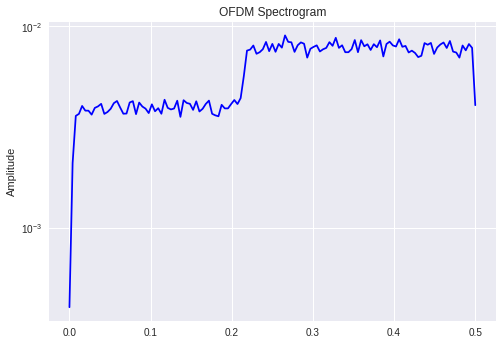

In [0]:
"""
  Unitary test of Emiter class
"""
# Channel code parameters + trellis generation
mem_size = np.array([2])
g_matrix = np.array([[0o5, 0o7]])
trellis = Trellis(mem_size, g_matrix)

# Modulation parameters
modulation_order = 4
frame_length = 20000

# OFDM parameters
nb_carriers = 128
cp_length = 10
off_carrier = 28


# Creation of the emiter
emiter = Emiter(cp_length, nb_carriers, modulation_order, trellis, nb_off_carriers=off_carrier)

# Basic unitary test
print("Modulation exponent: ", emiter.modulator.num_bits_symbol)

# Vizualization of trellis
#(emiter.get_trellis()).visualize()

# Test the frame modulation
# Generation of a frame 
frame = np.random.randint(0, high=2, size=(frame_length))
print("The frame length is : ",frame.shape)

# Channel Coding by the emiter
enc_frame = emiter.encode(frame)
print("The encoded frame length is : ", enc_frame.shape)

# Modulation operation by the emiter
mod_frame = emiter.modulate(enc_frame)
print("The modulated frame shape is : ", mod_frame.shape)


# Verification of the spectrum :
plot_spectrum(mod_frame,1)

In [0]:
"""
  AWGN Channel class
"""

class AWGN_Channel:
  
  """ Class of the AWGN channel.
  
  :mean: A float, mean of the gaussian noise.
  :var: A float, variance of the gaussian noise.
  :non_lin_coeff: A float, value of the non-linearity coefficient of the channel.
  :iq_imbalance: A float, value of the iq_imbalance.
    
  """
  def __init__(self, mean, var, non_lin_coeff=0, iq_imbalance=None):
    self.mean = mean
    self.var = var
    self.gamma = non_lin_coeff
    self.beta = iq_imbalance
  
  """ Return the value of the frame after get through the channel
  
  :mod_frame: An array, input of of the channel. Is the modulated frame from an 
    emiter.
  """  
  def get_trough(self, mod_frame):
      # Test if there is a non-linearity
      if slef.beta is not None:
        mod_frame = add_iq_imbalance(mod_frame)
        
      # Non linearity
      mod_frame -= self.gamma * np.abs(mod_frame) ** 2 * mod_frame
      
      # Add Gaussian noise
      output = mod_frame + np.random.normal(self.mean, self.variance,
                                        mod_frame.shape)
      # Add second non linearity
      if slef.beta is not None:
        output = add_iq_imbalance(output)
        
      # Non linearity for the second time
      output -= self.gamma * np.abs(output)**2 * output
  
  
  """ Add IQ imbalance to a given array
  :x: An array, input which will be imbalanced accodring to attributes of the 
    AWGN channel class
  """
  def add_iq_imbalance(x):
    return slef.beta * np.real(x) + 1j * np.imag(x)

In [0]:
### Monte-carlo simulations

min_error_frame = 3000; max_test = 5000;

step_db = 2; max_snr = 10; min_snr = 0;
snr_db = np.array(range(min_snr, max_snr, step_db))
BER = np.zeros((1,len(snr_db)))


for ind_SNR in range(len(snr_db)):
    # Init variables
    nb_tries = 0
    nb_frame_error = 0
    global_error_nb = 0
    # Monte-Carlo method
    while ((nb_tries < max_test) && (nb_frame_error < min_error_frame)):
        # Generation of the frames
        frame = randi([0 1], 1, frame_length);
        # Send the frame to the physical layer
        recieved_frame = physical_layer(frame, snr_db(ind_SNR), trellis)
        # Counting errors
        errors_num = sum(recieved_frame~=frame)
        # Look at the number of mistake
        if (errors_num > 0):
            # Add the number of frame errors
            nb_frame_error = nb_frame_error + 1
        global_error_nb = global_error_nb + errors_num
        # increase the number of tries
        nb_tries = nb_tries + 1
    BER(ind_SNR) = global_error_nb/(nb_tries * frame_length)
    print(['BER simulation completed at ',num2str(100 * ind_SNR/length(snr_db)),' %'])


In [0]:
### Printing results